<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/classification/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [0]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#def learning curve

In [3]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


Automatically created module for IPython interactive environment


#Load data

In [4]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(public_data, public_labels, test_size=0.3, stratify=public_labels, random_state=3)

In [16]:
X_train.shape

(91, 107)

#Vettorizzare i label

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(y_train)
test_labels_encoded = encoder.transform(y_test)

#Scalers

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

In [0]:
scalers_to_test = [StandardScaler(), RobustScaler()]

#SVM linear 

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [0]:
steps = [('scaler', StandardScaler()), ('red_dim', PCA()), ('clf', SVC(kernel='linear', random_state=1))]

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

In [0]:
# Designate distributions to sample hyperparameters from 
np.random.seed(123)
g_range = np.random.uniform(0.0, 0.3, 5).astype(float)
C_range = np.random.normal(1, 0.1, 5).astype(float)

# Check that gamma>0 and C>0 
C_range[C_range < 0] = 0.0001

In [0]:
parameteres = [{'scaler':[StandardScaler()], 'red_dim':[PCA()], 'red_dim__n_components':[9],'clf__C':list(C_range), 'clf__gamma':list(g_range)}]

In [0]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)


In [0]:
grid = RandomizedSearchCV(pipeline, param_distributions=parameteres, n_iter =10, cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
#per questo usare parentesi tonde per i kernel

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('red_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [37]:
print(f'score = {pipeline.score(X_test, y_test)}')

score = 0.5


In [38]:
print(pipeline.named_steps
    )

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'red_dim': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'clf': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)}


##Learning curve

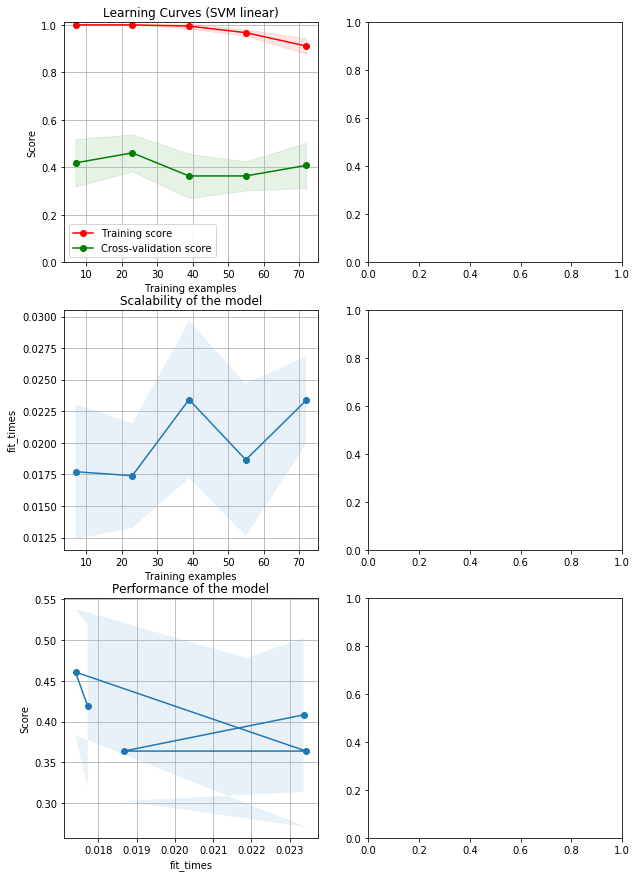

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (SVM linear)"

estimator = pipeline
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0.0, 1.01), cv=5, n_jobs=4)

plt.show()

#Built classification algorithm: Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier


In [0]:
neigh = KNeighborsClassifier(n_neighbors=10)

###PCA

In [0]:
neigh.fit(train_data_stand_pca, y_train_pca)
neigh.score(val_data_stand_pca, y_val_pca)

0.45

In [0]:
neigh.score(test_data_stand_pca, test_labels_dec)

0.20588235294117646

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = neigh.predict(X_val_pca)

cm = confusion_matrix(y_val_pca, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_val_pca, y_pred)))

[[ 1  2  2]
 [ 0 12  7]
 [ 0 11  5]]
Accuracy0.45


###LDA

In [0]:
neigh.fit(X_train_lda, y_train_lda)
neigh.score(X_val_lda, y_val_lda)

0.975

In [0]:
neigh.score(test_data_stand_lda, test_labels_dec)

0.14705882352941177

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = neigh.predict(X_val_lda)

cm = confusion_matrix(y_val_lda, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_val_lda, y_pred)))

[[ 5  0  0]
 [ 0 19  0]
 [ 0  1 15]]
Accuracy0.975


#Built classification algorithm: SVM

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC(gamma='auto')

###PCA

In [0]:
clf.fit(X_train_pca, y_train_pca)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
clf.score(X_val_pca, y_val_pca)

0.45

In [0]:
clf.score(test_data_stand_pca, test_labels_dec)

0.11764705882352941

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_val_pca)

cm = confusion_matrix(y_val_pca, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_val_pca, y_pred)))

ValueError: ignored

###LDA

In [0]:
clf.fit(X_train_lda, y_train_lda)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
clf.score(X_val_lda, y_val_lda)

0.95

In [0]:
clf.score(test_data_stand_lda, test_labels)

0.29411764705882354

In [0]:
y_pred

array(['large cell', 'squamous cell carcinoma', 'adenocarcinoma',
       'squamous cell carcinoma', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'large cell', 'squamous cell carcinoma',
       'large cell', 'large cell', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'squamous cell carcinoma', 'large cell',
       'large cell', 'large cell', 'squamous cell carcinoma',
       'adenocarcinoma', 'squamous cell carcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'large cell', 'squamous cell carcinoma',
       'large cell', 'large cell', 'large cell',
       'squamous cell carcinoma', 'large cell', 'squamous cell carcinoma',
       'large cell', 'large cell', 'large cell',
       'squamous cell carcinoma', 'large cell', 'large cell',
       'large cell', 'large cell', 'large cell'], dtype=object)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_val_lda)

cm = confusion_matrix(y_val_lda, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_val_lda, y_pred)))

[[ 4  0  1]
 [ 0 19  0]
 [ 0  1 15]]
Accuracy0.95


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.


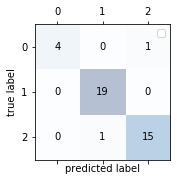

In [0]:
#matrice di confusione


fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
            ax.text(x=j,  y=i, s=cm[i, j],  va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


Text(0.5, 1.0, 'Confusion matrix public dataset')

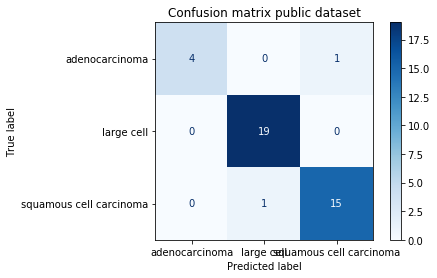

In [0]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf, X_val_lda, y_val_lda,
                                 display_labels=['adenocarcinoma', 'large cell', 'squamous cell carcinoma'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion matrix public dataset')